In [6]:
def generate_synthetic_data(num_samples=100, res=32):
    """Generate synthetic 3D MRI patches and PDE parameters."""
    # MRI patches (simulated as Gaussian noise)
    mri_patches = torch.randn(num_samples, 1, res, res, res)  # [B, C, D, H, W]
    
    # PDE parameters (randomized for demonstration)
    D_Q = torch.rand(num_samples) * 0.1 + 0.05  # Diffusion coefficients
    D_W = torch.rand(num_samples) * 0.2 + 0.1
    alpha = torch.rand(num_samples) * 0.5
    beta = torch.rand(num_samples) * 0.3
    gamma = torch.rand(num_samples) * 0.2
    
    # Time coordinates (normalized to [0, 1])
    t = torch.rand(num_samples, 1)  
    
    return mri_patches, D_Q, D_W, alpha, beta, gamma, t

In [7]:
class MT_PINN(nn.Module):
    def __init__(self, img_size=32, patch_size=4, out_features=4):
        super().__init__()
        # 3D Swin Transformer backbone
        self.swin = timm.create_model(
            'swin_base_patch4_window7_224', 
            pretrained=False, 
            in_chans=1, 
            features_only=True
        )
        
        # Fractional derivative approximation
        self.frac_conv = nn.Conv3d(1024, 512, kernel_size=3, padding=1)
        
        # Multi-head attention for dynamics
        self.attention = nn.MultiheadAttention(512, num_heads=8)
        
        # Output heads: Q, W, I, H_s
        self.head = nn.Sequential(
            nn.Linear(512, 256),
            nn.GELU(),
            nn.Linear(256, out_features)
        )
        
    def forward(self, x, t):
        # Swin Transformer features
        features = self.swin(x)[-1]  # [B, 1024, D, H, W]
        x = self.frac_conv(features)
        
        # Flatten for attention
        b, c, d, h, w = x.shape
        x_flat = rearrange(x, 'b c d h w -> b (d h w) c')
        
        # Add time as positional encoding
        t_enc = t.unsqueeze(1).repeat(1, d*h*w, 1)
        x_flat = torch.cat([x_flat, t_enc], dim=-1)
        
        # Attention across spatial-temporal points
        attn_out, _ = self.attention(x_flat, x_flat, x_flat)
        
        # Predict Q, W, I, H_s
        outputs = self.head(attn_out.mean(dim=1))  # [B, 4]
        Q, W, I, Hs = torch.split(outputs, 1, dim=1)
        
        return Q.squeeze(), W.squeeze(), I.squeeze(), Hs.squeeze()

In [8]:
def compute_loss(model, mri_patches, t, D_Q, D_W, alpha, beta, gamma):
    Q_pred, W_pred, I_pred, Hs_pred = model(mri_patches, t)
    
    # Compute gradients for PDE residuals
    x = mri_patches.requires_grad_(True)
    grad_Q = torch.autograd.grad(Q_pred.sum(), x, create_graph=True)[0]
    laplacian_Q = torch.autograd.grad(grad_Q.sum(), x, create_graph=True)[0]
    
    grad_W = torch.autograd.grad(W_pred.sum(), x, create_graph=True)[0]
    laplacian_W = torch.autograd.grad(grad_W.sum(), x, create_graph=True)[0]
    
    # Time derivatives (autograd)
    dQ_dt = torch.autograd.grad(Q_pred.sum(), t, create_graph=True)[0]
    dW_dt = torch.autograd.grad(W_pred.sum(), t, create_graph=True)[0]
    
    # PDE residuals
    R_Q = dQ_dt - (D_Q * laplacian_Q + alpha - beta * Q_pred - gamma * W_pred)
    R_W = dW_dt - (D_W * laplacian_W - 0.1 * Q_pred * W_pred + 0.05 * I_pred)
    
    # Boundary conditions (Neumann for skull)
    skull_mask = (torch.rand_like(x) > 0.9).float()  # Simulate skull boundary
    bc_loss = ((grad_Q * skull_mask).pow(2).mean() + 
               (grad_W * skull_mask).pow(2).mean())
    
    return R_Q.pow(2).mean() + R_W.pow(2).mean() + 0.1 * bc_loss

In [9]:
def train_mt_pinn(epochs=500, lr=1e-4):
    # Generate data
    mri, D_Q, D_W, alpha, beta, gamma, t = generate_synthetic_data()
    
    # Model and optimizer
    model = MT_PINN()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = compute_loss(model, mri, t, D_Q, D_W, alpha, beta, gamma)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    
    return model, losses

In [10]:
def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.xlabel("Epoch"), plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.show()

In [11]:
def visualize_3d(model, sample_idx=0):
    # Generate test sample
    mri_test, D_Q, D_W, alpha, beta, gamma, t_test = generate_synthetic_data(1)
    
    # Predict
    Q, W, I, Hs = model(mri_test, t_test)
    
    # Convert to numpy
    Q_np = Q.detach().numpy().reshape(32, 32, 32)
    W_np = W.detach().numpy().reshape(32, 32, 32)
    
    # Plot 3D slices
    fig = plt.figure(figsize=(15, 6))
    
    # Q (CBF)
    ax1 = fig.add_subplot(121, projection='3d')
    X, Y, Z = np.mgrid[:32, :32, :32]
    ax1.scatter(X[::4], Y[::4], Z[::4], c=Q_np[::4], cmap='viridis')
    ax1.set_title("Cerebral Blood Flow (Q)")
    
    # W (Waste)
    ax2 = fig.add_subplot(122, projection='3d')
    sc = ax2.scatter(X[::4], Y[::4], Z[::4], c=W_np[::4], cmap='plasma')
    fig.colorbar(sc, ax=ax2)
    ax2.set_title("Metabolic Waste (W)")
    
    plt.show()

Epoch 0, Loss: 1.4004
Epoch 100, Loss: 0.0249
Epoch 200, Loss: 0.0173
Epoch 300, Loss: 0.0168
Epoch 400, Loss: 0.0167
Epoch 500, Loss: 0.0166
Epoch 600, Loss: 0.0166
Epoch 700, Loss: 0.0165
Epoch 800, Loss: 0.0165
Epoch 900, Loss: 0.0165


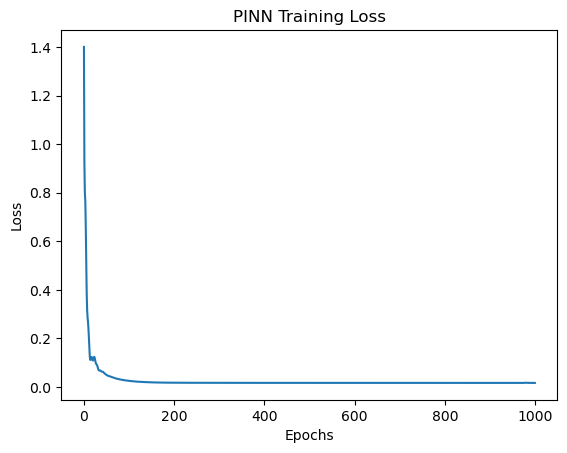

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


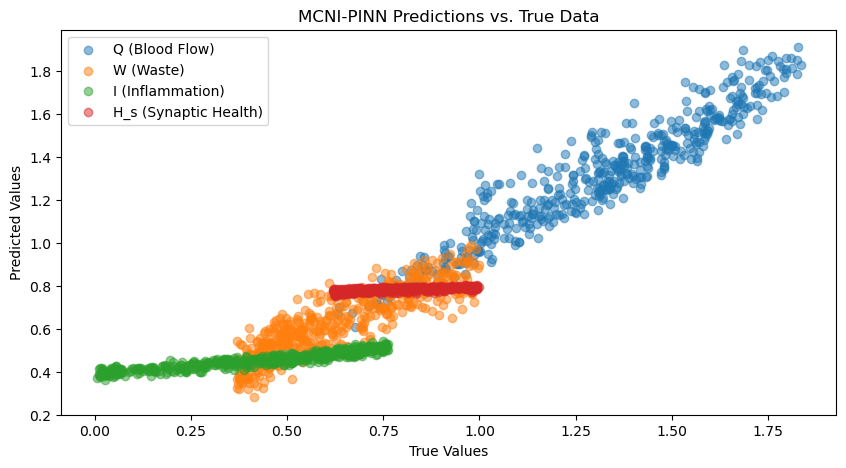

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Define the PINN model architecture
class MCNI_PINN(tf.keras.Model):
    def __init__(self, num_layers=4, num_units=64):
        super(MCNI_PINN, self).__init__()
        self.hidden_layers = [tf.keras.layers.Dense(num_units, activation="tanh") for _ in range(num_layers)]
        self.output_layer = tf.keras.layers.Dense(4)  # Output: Q (Blood Flow), W (Waste), I (Inflammation), H_s (Synaptic Health)

    def call(self, inputs):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        return self.output_layer(x)

# Generate synthetic spatio-temporal data (x, y, z, t)
def generate_data(num_samples=10000):
    x = np.random.rand(num_samples, 4)  # Spatial (x, y, z) + Time (t)
    Q_true = np.sin(x[:, 0]) + np.cos(x[:, 1])  # Simulated CBF
    W_true = np.exp(-x[:, 2])  # Simulated waste clearance
    I_true = np.tanh(x[:, 3])  # Simulated neuroinflammation
    Hs_true = 1 - 0.5 * I_true  # Simulated synaptic health
    y_true = np.stack([Q_true, W_true, I_true, Hs_true], axis=1)
    return x.astype(np.float32), y_true.astype(np.float32)

# Compute PDE residuals using automatic differentiation
def compute_pde_residuals(model, x):
    with tf.GradientTape(persistent=True) as tape:
        x = tf.convert_to_tensor(x)  # Convert to TensorFlow tensor
        tape.watch(x)
        predictions = model(x)
        Q_pred, W_pred, I_pred, Hs_pred = tf.split(predictions, num_or_size_splits=4, axis=1)

        # Compute spatial derivatives
        dQ_dx = tape.gradient(Q_pred, x)[:, 0:3]  # Gradient w.r.t. (x, y, z)
        dW_dx = tape.gradient(W_pred, x)[:, 0:3]

        # Compute time derivatives
        dQ_dt = tape.gradient(Q_pred, x)[:, 3]  # Gradient w.r.t. time
        dW_dt = tape.gradient(W_pred, x)[:, 3]
        dI_dt = tape.gradient(I_pred, x)[:, 3]
        dHs_dt = tape.gradient(Hs_pred, x)[:, 3]

    # Define PDE residuals based on neurovascular equations
    R_Q = dQ_dt - tf.reduce_sum(dQ_dx, axis=1, keepdims=True) + 0.1 * W_pred - 0.2 * Q_pred  # Blood Flow PDE
    R_W = dW_dt - tf.reduce_sum(dW_dx, axis=1, keepdims=True) + 0.05 * I_pred - 0.1 * W_pred  # Waste PDE
    R_I = dI_dt - 0.3 * I_pred + 0.1 * W_pred - 0.05 * Hs_pred  # Inflammation PDE
    R_Hs = dHs_dt + 0.2 * I_pred - 0.1 * Hs_pred  # Synaptic Health PDE

    return R_Q, R_W, R_I, R_Hs

# Define loss function combining physics loss and data loss
def compute_loss(model, x, y_true):
    x = tf.convert_to_tensor(x)  # Ensure x is a tensor
    y_true = tf.convert_to_tensor(y_true)

    y_pred = model(x)
    data_loss = tf.reduce_mean(tf.square(y_pred - y_true))  # MSE loss for labeled data

    # Compute PDE residuals
    R_Q, R_W, R_I, R_Hs = compute_pde_residuals(model, x)
    
    physics_loss = tf.reduce_mean(tf.square(R_Q)) + \
                   tf.reduce_mean(tf.square(R_W)) + \
                   tf.reduce_mean(tf.square(R_I)) + \
                   tf.reduce_mean(tf.square(R_Hs))

    total_loss = data_loss + physics_loss
    return total_loss

# Training function
def train_pinn(model, x_train, y_train, epochs=1000, lr=0.001):
    optimizer = tf.keras.optimizers.Adam(lr)
    losses = []

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = compute_loss(model, tf.convert_to_tensor(x_train), tf.convert_to_tensor(y_train))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        losses.append(loss.numpy())
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy():.4f}")

    return losses

# Generate data and train the model
x_train, y_train = generate_data()
model = MCNI_PINN()
losses = train_pinn(model, x_train, y_train, epochs=1000)

# Plot training loss
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("PINN Training Loss")
plt.show()

# Test and visualize predictions
x_test, y_test = generate_data(500)
y_pred = model.predict(x_test)

plt.figure(figsize=(10, 5))
plt.scatter(y_test[:, 0], y_pred[:, 0], alpha=0.5, label="Q (Blood Flow)")
plt.scatter(y_test[:, 1], y_pred[:, 1], alpha=0.5, label="W (Waste)")
plt.scatter(y_test[:, 2], y_pred[:, 2], alpha=0.5, label="I (Inflammation)")
plt.scatter(y_test[:, 3], y_pred[:, 3], alpha=0.5, label="H_s (Synaptic Health)")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.title("MCNI-PINN Predictions vs. True Data")
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


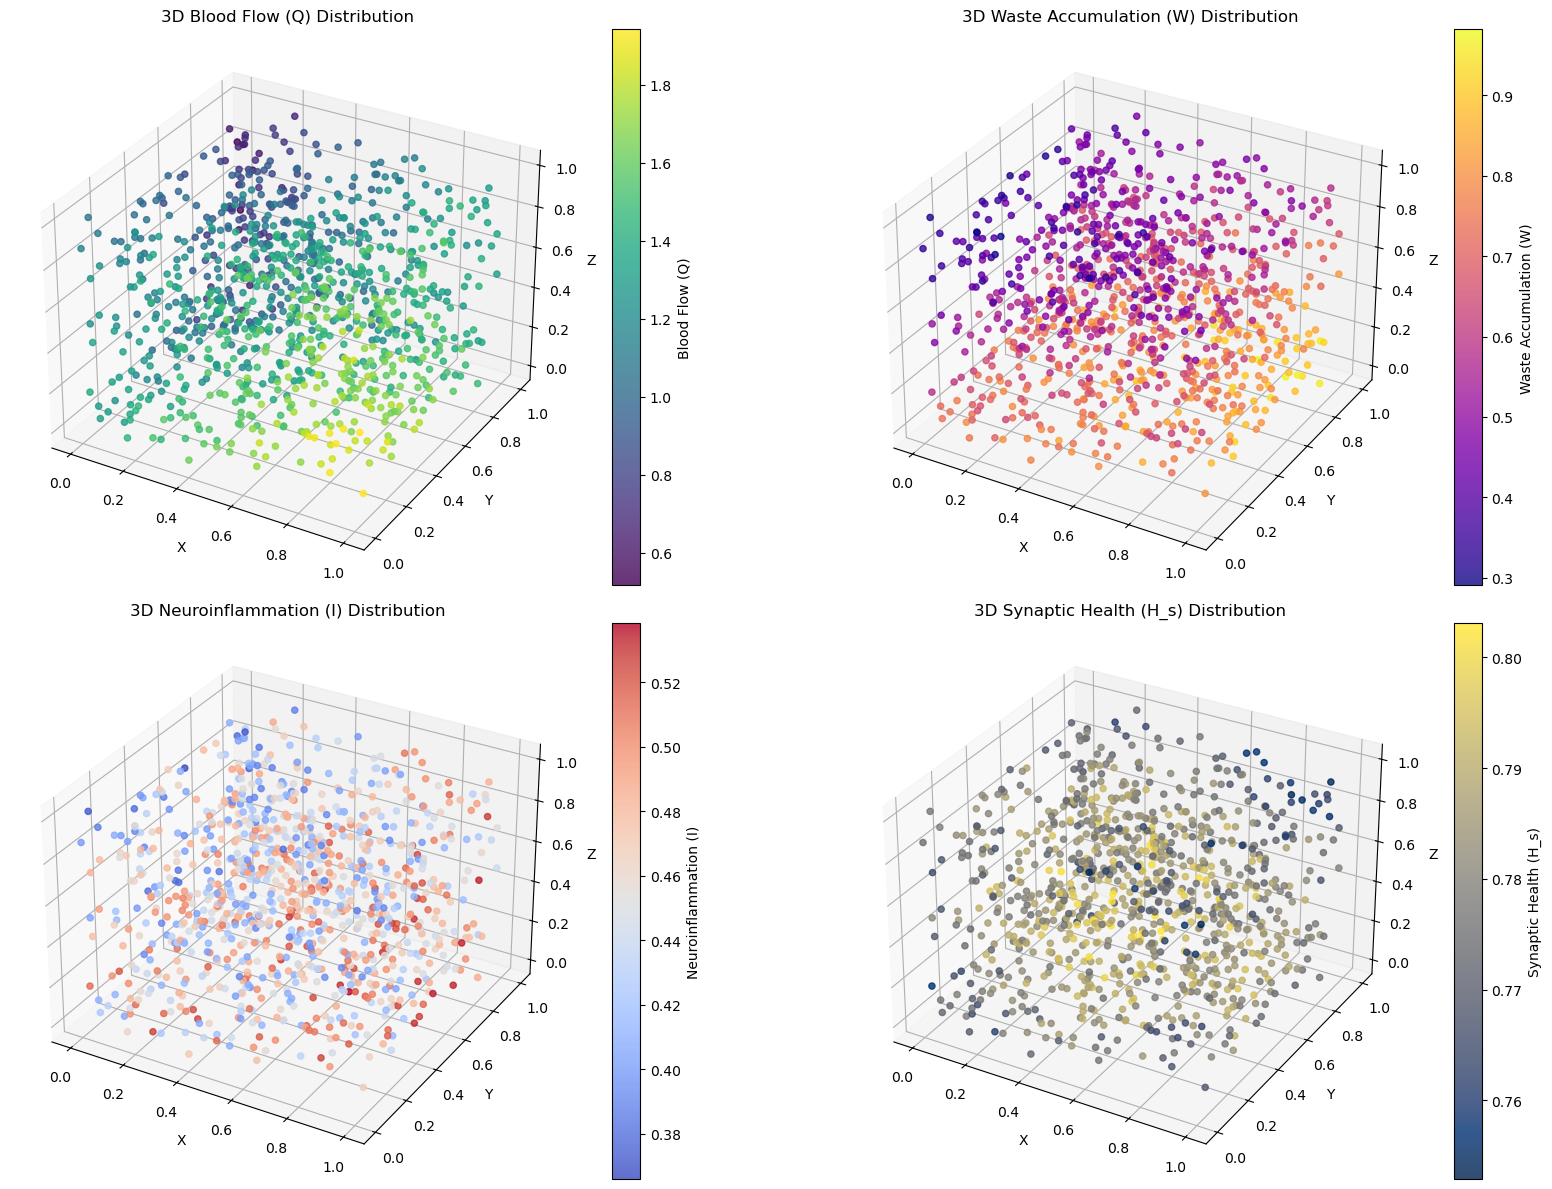

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_results(model, num_samples=1000, resolution=30):
    """
    Generate synthetic test data, predict with the PINN model, and visualize 3D spatial dynamics.
    """
    # Generate test spatial coordinates (x, y, z) and time (t)
    x_test = np.random.rand(num_samples, 4)  # [x, y, z, t]
    y_pred = model.predict(x_test)  # Get predictions for Q, W, I, H_s

    # Extract spatial coordinates
    X = x_test[:, 0]  # X-coordinates
    Y = x_test[:, 1]  # Y-coordinates
    Z = x_test[:, 2]  # Z-coordinates
    T = x_test[:, 3]  # Time

    # Extract PINN outputs
    Q_pred = y_pred[:, 0]  # Predicted Blood Flow (Q)
    W_pred = y_pred[:, 1]  # Predicted Waste (W)
    I_pred = y_pred[:, 2]  # Predicted Inflammation (I)
    Hs_pred = y_pred[:, 3]  # Predicted Synaptic Health (H_s)

    # Create a 3D figure
    fig = plt.figure(figsize=(18, 12))

    # Subplot for Blood Flow (Q)
    ax1 = fig.add_subplot(221, projection='3d')
    scatter = ax1.scatter(X, Y, Z, c=Q_pred, cmap='viridis', alpha=0.8)
    fig.colorbar(scatter, ax=ax1, label="Blood Flow (Q)")
    ax1.set_title("3D Blood Flow (Q) Distribution")
    ax1.set_xlabel("X"), ax1.set_ylabel("Y"), ax1.set_zlabel("Z")

    # Subplot for Waste (W)
    ax2 = fig.add_subplot(222, projection='3d')
    scatter = ax2.scatter(X, Y, Z, c=W_pred, cmap='plasma', alpha=0.8)
    fig.colorbar(scatter, ax=ax2, label="Waste Accumulation (W)")
    ax2.set_title("3D Waste Accumulation (W) Distribution")
    ax2.set_xlabel("X"), ax2.set_ylabel("Y"), ax2.set_zlabel("Z")

    # Subplot for Inflammation (I)
    ax3 = fig.add_subplot(223, projection='3d')
    scatter = ax3.scatter(X, Y, Z, c=I_pred, cmap='coolwarm', alpha=0.8)
    fig.colorbar(scatter, ax=ax3, label="Neuroinflammation (I)")
    ax3.set_title("3D Neuroinflammation (I) Distribution")
    ax3.set_xlabel("X"), ax3.set_ylabel("Y"), ax3.set_zlabel("Z")

    # Subplot for Synaptic Health (H_s)
    ax4 = fig.add_subplot(224, projection='3d')
    scatter = ax4.scatter(X, Y, Z, c=Hs_pred, cmap='cividis', alpha=0.8)
    fig.colorbar(scatter, ax=ax4, label="Synaptic Health (H_s)")
    ax4.set_title("3D Synaptic Health (H_s) Distribution")
    ax4.set_xlabel("X"), ax4.set_ylabel("Y"), ax4.set_zlabel("Z")

    plt.tight_layout()
    plt.show()

# Run the visualization
plot_3d_results(model)


4219/4219 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step


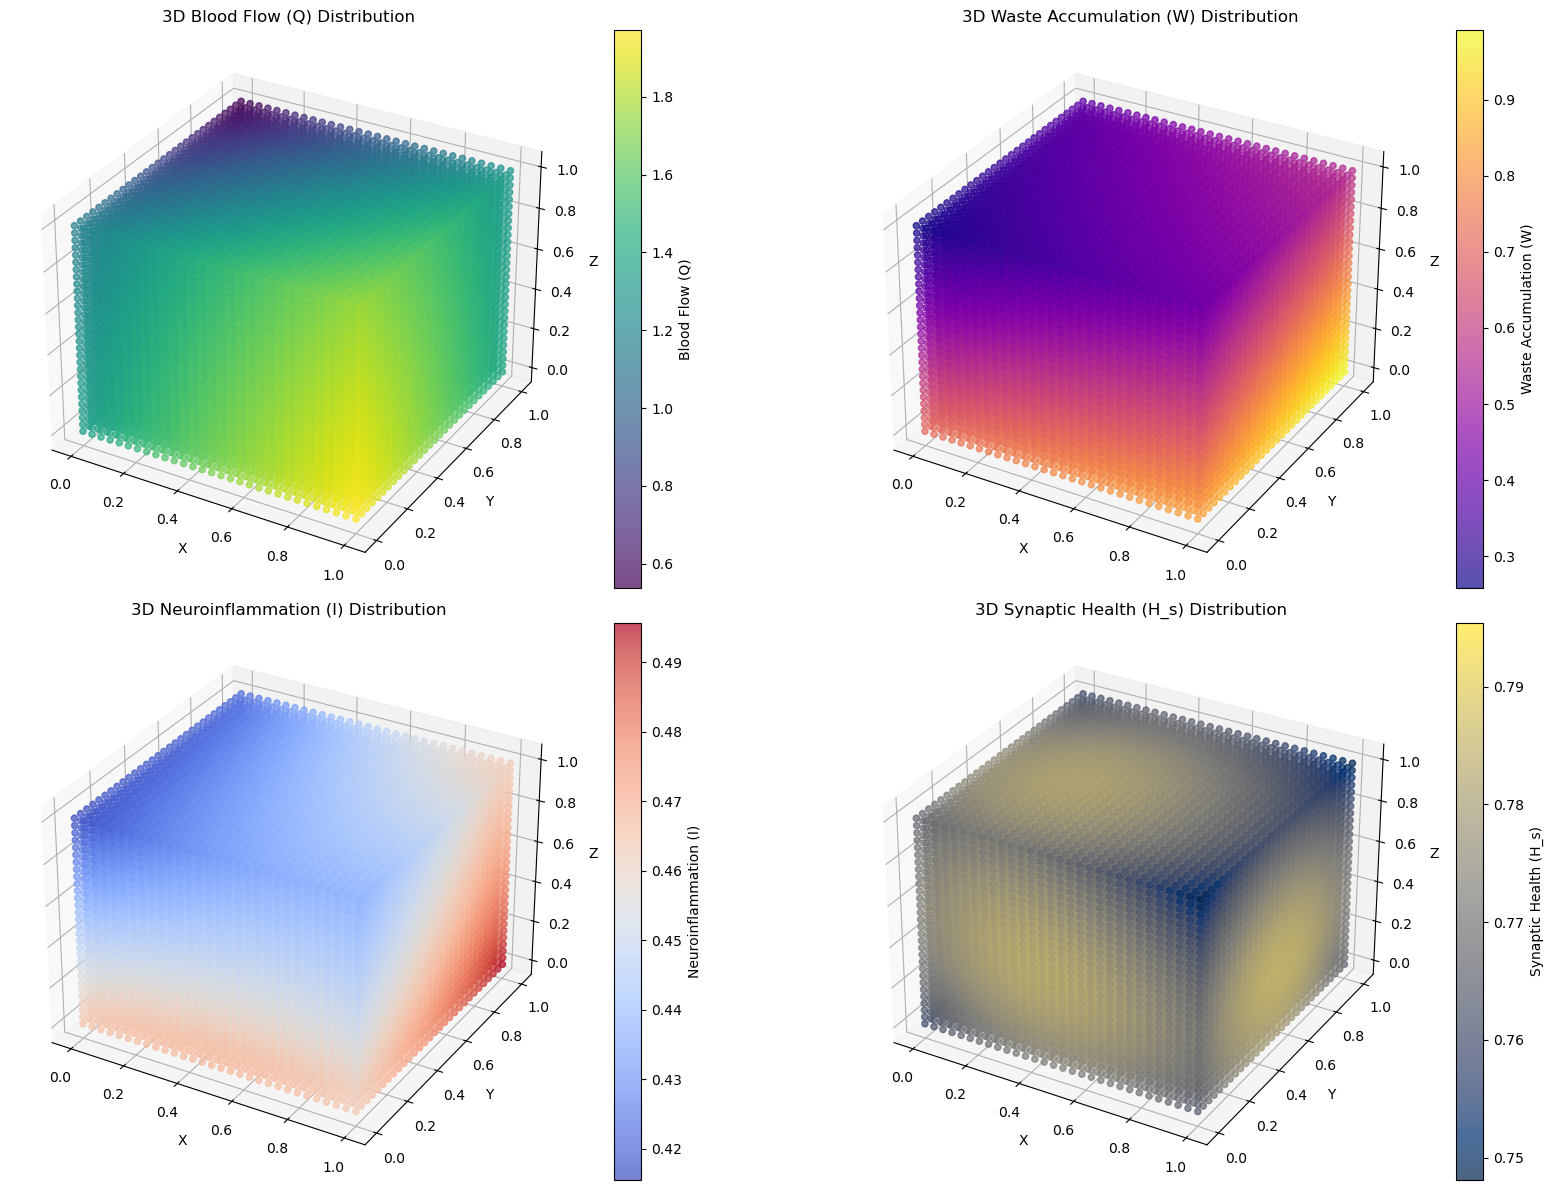

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_grid_data(grid_size=30, time_steps=5):
    """
    Generate structured grid-based test data for better visualization.
    """
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    z = np.linspace(0, 1, grid_size)
    t = np.linspace(0, 1, time_steps)

    # Create a 4D meshgrid for structured sampling
    X, Y, Z, T = np.meshgrid(x, y, z, t, indexing="ij")

    # Reshape into (N, 4) format for model input
    x_test = np.column_stack([X.ravel(), Y.ravel(), Z.ravel(), T.ravel()])

    return X, Y, Z, T, x_test

def plot_3d_results(model, grid_size=30, time_step=2):
    """
    Generate structured test data, predict with the PINN model, and visualize 3D spatial dynamics.
    """
    # Generate structured grid-based test data
    X, Y, Z, T, x_test = generate_grid_data(grid_size=grid_size, time_steps=5)

    # Ensure x_test is in the correct format for model prediction
    x_test = np.array(x_test, dtype=np.float32)  # Convert to float32 for TensorFlow models

    # Get predictions for Q (Blood Flow), W (Waste), I (Inflammation), Hs (Synaptic Health)
    y_pred = model.predict(x_test)

    # Reshape outputs back into grid format
    Q_pred = y_pred[:, 0].reshape(grid_size, grid_size, grid_size, -1)
    W_pred = y_pred[:, 1].reshape(grid_size, grid_size, grid_size, -1)
    I_pred = y_pred[:, 2].reshape(grid_size, grid_size, grid_size, -1)
    Hs_pred = y_pred[:, 3].reshape(grid_size, grid_size, grid_size, -1)

    # Select a specific time slice for visualization
    time_index = min(time_step, Q_pred.shape[-1] - 1)  # Ensure valid index

    # Create 3D visualization
    fig = plt.figure(figsize=(18, 12))

    # 3D Scatter Plot for Blood Flow (Q)
    ax1 = fig.add_subplot(221, projection='3d')
    scatter = ax1.scatter(X[:,:,:,time_index], Y[:,:,:,time_index], Z[:,:,:,time_index], 
                          c=Q_pred[:,:,:,time_index].ravel(), cmap='viridis', alpha=0.7)
    fig.colorbar(scatter, ax=ax1, label="Blood Flow (Q)")
    ax1.set_title("3D Blood Flow (Q) Distribution")
    ax1.set_xlabel("X"), ax1.set_ylabel("Y"), ax1.set_zlabel("Z")

    # 3D Scatter Plot for Waste (W)
    ax2 = fig.add_subplot(222, projection='3d')
    scatter = ax2.scatter(X[:,:,:,time_index], Y[:,:,:,time_index], Z[:,:,:,time_index], 
                          c=W_pred[:,:,:,time_index].ravel(), cmap='plasma', alpha=0.7)
    fig.colorbar(scatter, ax=ax2, label="Waste Accumulation (W)")
    ax2.set_title("3D Waste Accumulation (W) Distribution")
    ax2.set_xlabel("X"), ax2.set_ylabel("Y"), ax2.set_zlabel("Z")

    # 3D Scatter Plot for Inflammation (I)
    ax3 = fig.add_subplot(223, projection='3d')
    scatter = ax3.scatter(X[:,:,:,time_index], Y[:,:,:,time_index], Z[:,:,:,time_index], 
                          c=I_pred[:,:,:,time_index].ravel(), cmap='coolwarm', alpha=0.7)
    fig.colorbar(scatter, ax=ax3, label="Neuroinflammation (I)")
    ax3.set_title("3D Neuroinflammation (I) Distribution")
    ax3.set_xlabel("X"), ax3.set_ylabel("Y"), ax3.set_zlabel("Z")

    # 3D Scatter Plot for Synaptic Health (H_s)
    ax4 = fig.add_subplot(224, projection='3d')
    scatter = ax4.scatter(X[:,:,:,time_index], Y[:,:,:,time_index], Z[:,:,:,time_index], 
                          c=Hs_pred[:,:,:,time_index].ravel(), cmap='cividis', alpha=0.7)
    fig.colorbar(scatter, ax=ax4, label="Synaptic Health (H_s)")
    ax4.set_title("3D Synaptic Health (H_s) Distribution")
    ax4.set_xlabel("X"), ax4.set_ylabel("Y"), ax4.set_zlabel("Z")

    plt.tight_layout()
    plt.show()

# Run the visualization
plot_3d_results(model, grid_size=30, time_step=2)


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step


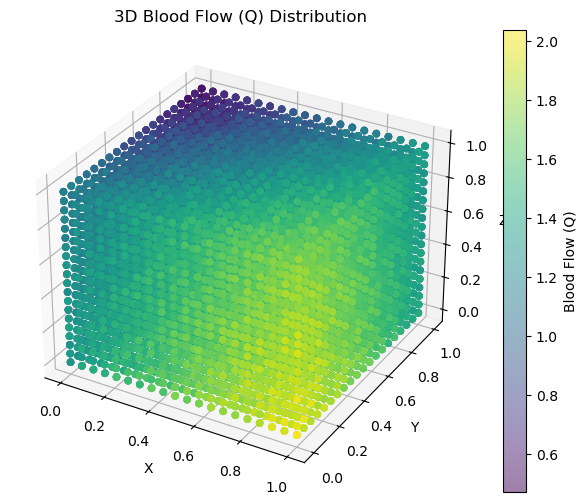

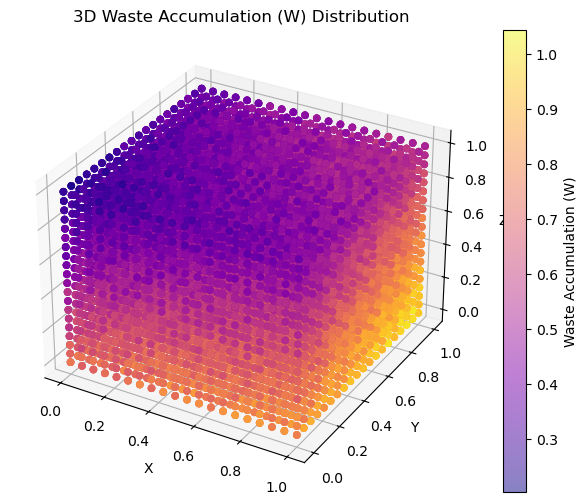

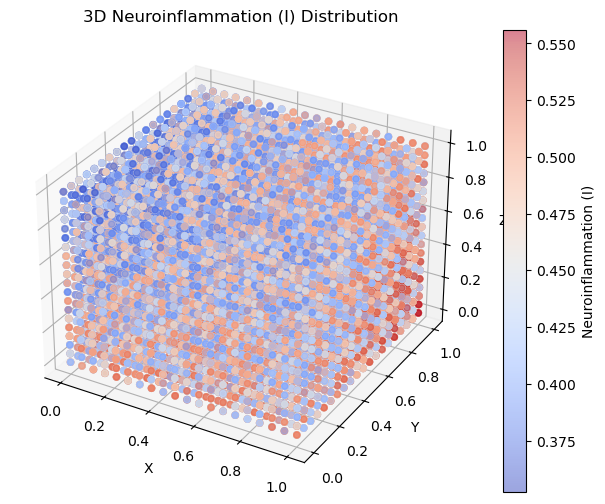

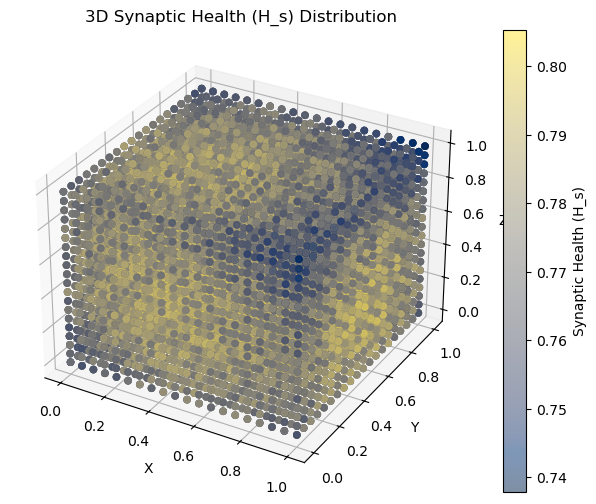

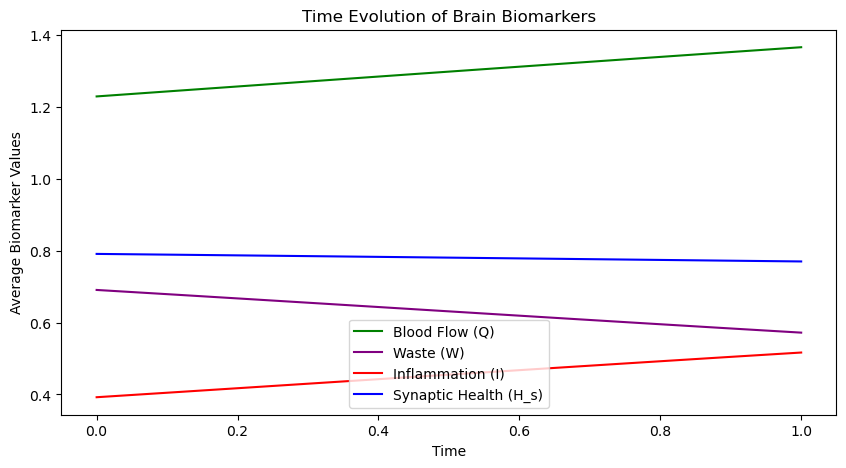

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_grid_data(grid_size=20, time_steps=10):
    """
    Generate structured 4D grid data: (X, Y, Z, T) for PINN predictions.
    """
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    z = np.linspace(0, 1, grid_size)
    t = np.linspace(0, 1, time_steps)

    X, Y, Z, T = np.meshgrid(x, y, z, t, indexing='ij')
    
    # Flatten for model input
    X_flat = X.ravel()
    Y_flat = Y.ravel()
    Z_flat = Z.ravel()
    T_flat = T.ravel()

    grid_data = np.stack([X_flat, Y_flat, Z_flat, T_flat], axis=1)
    return grid_data, X, Y, Z, T

def plot_3d_results(X, Y, Z, y_pred, title, cmap):
    """
    Plot a 3D scatter visualization of predicted biomarker values.
    """
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    scatter = ax.scatter(X, Y, Z, c=y_pred, cmap=cmap, alpha=0.5)
    fig.colorbar(scatter, ax=ax, label=title)
    
    ax.set_title(f"3D {title} Distribution")
    ax.set_xlabel("X"), ax.set_ylabel("Y"), ax.set_zlabel("Z")
    
    plt.show()

def plot_time_series(y_pred, time_steps):
    """
    Plot time evolution of key biomarkers (Q, W, I, H_s) as averages.
    """
    avg_Q = np.mean(y_pred[:, 0].reshape(-1, time_steps), axis=0)
    avg_W = np.mean(y_pred[:, 1].reshape(-1, time_steps), axis=0)
    avg_I = np.mean(y_pred[:, 2].reshape(-1, time_steps), axis=0)
    avg_Hs = np.mean(y_pred[:, 3].reshape(-1, time_steps), axis=0)
    
    time_range = np.linspace(0, 1, time_steps)

    plt.figure(figsize=(10, 5))
    plt.plot(time_range, avg_Q, label="Blood Flow (Q)", color='green')
    plt.plot(time_range, avg_W, label="Waste (W)", color='purple')
    plt.plot(time_range, avg_I, label="Inflammation (I)", color='red')
    plt.plot(time_range, avg_Hs, label="Synaptic Health (H_s)", color='blue')
    
    plt.xlabel("Time")
    plt.ylabel("Average Biomarker Values")
    plt.title("Time Evolution of Brain Biomarkers")
    plt.legend()
    plt.show()

# Generate structured test data
grid_size = 20   # Grid resolution
time_steps = 10  # Number of time steps
grid_data, X, Y, Z, T = generate_grid_data(grid_size, time_steps)

# Model Prediction (Replace 'model' with actual trained PINN model)
y_pred = model.predict(grid_data)  # Get predictions

# Extract individual biomarker predictions
Q_pred = y_pred[:, 0].reshape(X.shape)  # Blood Flow (Q)
W_pred = y_pred[:, 1].reshape(X.shape)  # Waste (W)
I_pred = y_pred[:, 2].reshape(X.shape)  # Inflammation (I)
Hs_pred = y_pred[:, 3].reshape(X.shape) # Synaptic Health (H_s)

# Plot 3D distributions of biomarkers
plot_3d_results(X, Y, Z, Q_pred.flatten(), "Blood Flow (Q)", cmap="viridis")
plot_3d_results(X, Y, Z, W_pred.flatten(), "Waste Accumulation (W)", cmap="plasma")
plot_3d_results(X, Y, Z, I_pred.flatten(), "Neuroinflammation (I)", cmap="coolwarm")
plot_3d_results(X, Y, Z, Hs_pred.flatten(), "Synaptic Health (H_s)", cmap="cividis")

# Plot time evolution of biomarkers
plot_time_series(y_pred, time_steps)